# CNN_3channel_VGG19_FineTune

Abstract:
- single channel: band_avg
- CNN, small net

Result:
- 增大网络的各个参数，只是把train数据的拟合程度增加了（到了99%），而cv数据的泛化能力仍然只有87%，说明，特征还需要进一步的提取来增加系统的泛化能力。

References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2

import gc

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_3channel_VGG19_FineTune'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: SC_Iceberg_Classifier_CNN_3channel_VGG19_FineTune_20180110_084730


### Folder Pathes

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\Kaggle\statoil-iceberg-classifier-challenge\input
log_path: D:\Kaggle\statoil-iceberg-classifier-challenge\log
model_path: D:\Kaggle\statoil-iceberg-classifier-challenge\model
output_path: D:\Kaggle\statoil-iceberg-classifier-challenge\output


### Unzip files

In [5]:
# with lzma.open("train.json.7z") as f:
#     file_content = f.read()

In [6]:
# Unzip(input_path, os.path.join(input_path, 'sample_submission.csv.7z'))
# Unzip(input_path, os.path.join(input_path, 'test.json.7z'))
# Unzip(input_path, os.path.join(input_path, 'train.json.7z'))

### Basic functions

In [7]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

### Load data

In [8]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [9]:
is_iceberg_path = os.path.join(input_path, 'is_iceberg.p')
y_data = pickle.load(open(is_iceberg_path, mode='rb'))
describe(y_data)

(1604,) 0 1 12936


In [10]:
%%time
#Load orignal data
inc_angle_data_path = os.path.join(input_path, 'inc_angle_data.p')
inc_angle_test_path = os.path.join(input_path, 'inc_angle_test.p')

inc_angle_data = pickle.load(open(inc_angle_data_path, mode='rb'))
inc_angle_test = pickle.load(open(inc_angle_test_path, mode='rb'))

describe(inc_angle_data)
describe(inc_angle_test)

(1604,) 0.0 45.9375 12936
(8424,) 23.0805 50.66178518 67496
Wall time: 7.99 ms


In [11]:
%%time
#Load orignal data
band1_data_path = os.path.join(input_path, 'band1_data_gray.p')
band2_data_path = os.path.join(input_path, 'band2_data_gray.p')
band1_test_path = os.path.join(input_path, 'band1_test_gray.p')
band2_test_path = os.path.join(input_path, 'band2_test_gray.p')

band1_data = pickle.load(open(band1_data_path, mode='rb'))
band2_data = pickle.load(open(band2_data_path, mode='rb'))
band1_test = pickle.load(open(band1_test_path, mode='rb'))
band2_test = pickle.load(open(band2_test_path, mode='rb'))

describe(band1_data)
describe(band2_data)
describe(band1_test)
describe(band2_test)

(1604, 75, 75) 0.0 1.0 128
(1604, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
Wall time: 2.1 s


In [12]:
%%time
#Load orignal data
band_sub_data = np.fabs(np.subtract(band1_data, band2_data))
band_sub_test = np.fabs(np.subtract(band1_test, band2_test))
band_min_data = np.minimum(band1_data, band2_data)
band_min_test = np.minimum(band1_test, band2_test)
band_max_data = np.maximum(band1_data, band2_data)
band_max_test = np.maximum(band1_test, band2_test)

describe(band_sub_data)
describe(band_sub_test)
describe(band_min_data)
describe(band_min_test)
describe(band_max_data)
describe(band_max_test)

(1604, 75, 75) 0.0 0.979400825264 72180128
(8424, 75, 75) 0.0 0.930272493331 379080128
(1604, 75, 75) 0.0 1.0 72180128
(8424, 75, 75) 0.0 1.0 379080128
(1604, 75, 75) 0.0210369138693 1.0 72180128
(8424, 75, 75) 0.0 1.0 379080128
Wall time: 1.6 s


In [13]:
%%time
#Load orignal data
band_sub_data = np.fabs(np.subtract(band1_data, band2_data))
band_sub_test = np.fabs(np.subtract(band1_test, band2_test))
band_min_data = np.minimum(band1_data, band2_data)
band_min_test = np.minimum(band1_test, band2_test)
band_max_data = np.maximum(band1_data, band2_data)
band_max_test = np.maximum(band1_test, band2_test)

describe(band_sub_data)
describe(band_sub_test)
describe(band_min_data)
describe(band_min_test)
describe(band_max_data)
describe(band_max_test)

(1604, 75, 75) 0.0 0.979400825264 72180128
(8424, 75, 75) 0.0 0.930272493331 379080128
(1604, 75, 75) 0.0 1.0 72180128
(8424, 75, 75) 0.0 1.0 379080128
(1604, 75, 75) 0.0210369138693 1.0 72180128
(8424, 75, 75) 0.0 1.0 379080128
Wall time: 1.84 s


In [14]:
%%time
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis],
                         band_max_data[:, :, :, np.newaxis]], axis=-1)
describe(x_data)
# del band1_data
# del band2_data
# del band_avg_data
gc.collect()

x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis],
                         band_max_test[:, :, :, np.newaxis]], axis=-1)
describe(x_test)
# del band1_test
# del band2_test
# del band_avg_test
gc.collect()

(1604, 75, 75, 3) 0.0 1.0 216540144
(8424, 75, 75, 3) 0.0 1.0 1137240144
Wall time: 1.27 s


In [15]:
%%time
x_train, x_val, inc_angle_train, inc_angle_val, y_train, y_val = train_test_split(x_data, inc_angle_data, y_data, test_size=0.1, random_state=31)
describe(x_train)
describe(x_val)
describe(inc_angle_train)
describe(inc_angle_val)
describe(y_train)
describe(y_val)

(1443, 75, 75, 3) 0.0 1.0 194805144
(161, 75, 75, 3) 0.0 1.0 21735144
(1443,) 0.0 45.9375 23112
(161,) 0.0 45.2814 2600
(1443,) 0 1 23112
(161,) 0 1 2600
Wall time: 140 ms


## 2. Build model

In [16]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

from keras.applications.vgg19 import VGG19, preprocess_input

Using TensorFlow backend.


In [17]:
def build_model():
    base_model = VGG19(weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = True

    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [18]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [19]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [20]:
def get_lr(x):
    lr = round(1e-4 * 0.995 ** x, 6)
    if lr < 1e-5:
        lr = 1e-5
    print(lr, end='  ')
    return lr

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\Kaggle\statoil-iceberg-classifier-challenge\log\SC_Iceberg_Classifier_CNN_3channel_VGG19_FineTune_20180110_084730


In [21]:
datagen = ImageDataGenerator(
    zoom_range = 0.2,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [22]:
%%time
batch_size = 8
# steps_per_epoch = 1 * len(x_train) / batch_size
hist = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True, seed=2019),
    steps_per_epoch=100,
    epochs=300, #1 for ETA, 0 for silent
    verbose=1,
    max_queue_size=128,
    callbacks=[annealer],
    workers=32,
    validation_data=(x_val, y_val)
)

0.0001  Epoch 1/300
100/100 [==============================] - 94s 940ms/step - loss: 0.7094 - acc: 0.5304 - val_loss: 0.6334 - val_acc: 0.6211
0.0001  Epoch 2/300
100/100 [==============================] - 88s 882ms/step - loss: 0.6614 - acc: 0.5750 - val_loss: 0.6947 - val_acc: 0.5466
9.9e-05  Epoch 3/300
100/100 [==============================] - 88s 882ms/step - loss: 0.6911 - acc: 0.5238 - val_loss: 0.6924 - val_acc: 0.5466
9.9e-05  Epoch 4/300
100/100 [==============================] - 88s 878ms/step - loss: 0.7018 - acc: 0.4804 - val_loss: 0.6928 - val_acc: 0.5466
9.8e-05  Epoch 5/300
100/100 [==============================] - 88s 878ms/step - loss: 0.6650 - acc: 0.5562 - val_loss: 0.6043 - val_acc: 0.6460
9.8e-05  Epoch 6/300
100/100 [==============================] - 88s 882ms/step - loss: 0.7217 - acc: 0.5725 - val_loss: 0.6799 - val_acc: 0.5466
9.7e-05  Epoch 7/300
100/100 [==============================] - 88s 878ms/step - loss: 0.6902 - acc: 0.5446 - val_loss: 0.6725 - val

100/100 [==============================] - 88s 878ms/step - loss: 0.6910 - acc: 0.5329 - val_loss: 0.6894 - val_acc: 0.5466
7.5e-05  Epoch 58/300
100/100 [==============================] - 88s 880ms/step - loss: 0.6916 - acc: 0.5300 - val_loss: 0.6894 - val_acc: 0.5466
7.5e-05  Epoch 59/300
100/100 [==============================] - 88s 878ms/step - loss: 0.6918 - acc: 0.5283 - val_loss: 0.6895 - val_acc: 0.5466
7.4e-05  Epoch 60/300
100/100 [==============================] - 88s 881ms/step - loss: 0.6918 - acc: 0.5262 - val_loss: 0.6895 - val_acc: 0.5466
7.4e-05  Epoch 61/300
100/100 [==============================] - 88s 878ms/step - loss: 0.6891 - acc: 0.5500 - val_loss: 0.6893 - val_acc: 0.5466
7.4e-05  Epoch 62/300
100/100 [==============================] - 88s 878ms/step - loss: 0.6917 - acc: 0.5254 - val_loss: 0.6893 - val_acc: 0.5466
7.3e-05  Epoch 63/300
100/100 [==============================] - 88s 880ms/step - loss: 0.6916 - acc: 0.5275 - val_loss: 0.6893 - val_acc: 0.5466


100/100 [==============================] - 87s 875ms/step - loss: 0.6913 - acc: 0.5304 - val_loss: 0.6894 - val_acc: 0.5466
5.7e-05  Epoch 114/300
100/100 [==============================] - 88s 879ms/step - loss: 0.6921 - acc: 0.5238 - val_loss: 0.6894 - val_acc: 0.5466
5.6e-05  Epoch 115/300
100/100 [==============================] - 88s 878ms/step - loss: 0.6911 - acc: 0.5333 - val_loss: 0.6894 - val_acc: 0.5466
5.6e-05  Epoch 116/300
100/100 [==============================] - 88s 879ms/step - loss: 0.6931 - acc: 0.5162 - val_loss: 0.6894 - val_acc: 0.5466
5.6e-05  Epoch 117/300
100/100 [==============================] - 88s 878ms/step - loss: 0.6899 - acc: 0.5437 - val_loss: 0.6894 - val_acc: 0.5466
5.6e-05  Epoch 118/300
100/100 [==============================] - 88s 880ms/step - loss: 0.6921 - acc: 0.5238 - val_loss: 0.6894 - val_acc: 0.5466
5.5e-05  Epoch 119/300
100/100 [==============================] - 88s 877ms/step - loss: 0.6924 - acc: 0.5179 - val_loss: 0.6895 - val_acc: 0

4.3e-05  Epoch 169/300
100/100 [==============================] - 87s 873ms/step - loss: 0.6896 - acc: 0.5467 - val_loss: 0.6894 - val_acc: 0.5466
4.3e-05  Epoch 170/300
100/100 [==============================] - 88s 875ms/step - loss: 0.6919 - acc: 0.5238 - val_loss: 0.6894 - val_acc: 0.5466
4.3e-05  Epoch 171/300
100/100 [==============================] - 87s 873ms/step - loss: 0.6905 - acc: 0.5392 - val_loss: 0.6894 - val_acc: 0.5466
4.2e-05  Epoch 172/300
100/100 [==============================] - 87s 874ms/step - loss: 0.6920 - acc: 0.5262 - val_loss: 0.6894 - val_acc: 0.5466
4.2e-05  Epoch 173/300
100/100 [==============================] - 87s 873ms/step - loss: 0.6928 - acc: 0.5183 - val_loss: 0.6895 - val_acc: 0.5466
4.2e-05  Epoch 174/300
100/100 [==============================] - 88s 875ms/step - loss: 0.6904 - acc: 0.5375 - val_loss: 0.6894 - val_acc: 0.5466
4.2e-05  Epoch 175/300
100/100 [==============================] - 87s 875ms/step - loss: 0.6909 - acc: 0.5337 - val_lo

3.3e-05  Epoch 225/300
100/100 [==============================] - 87s 868ms/step - loss: 0.6964 - acc: 0.4862 - val_loss: 0.6895 - val_acc: 0.5466
3.2e-05  Epoch 226/300
100/100 [==============================] - 87s 872ms/step - loss: 0.6906 - acc: 0.5400 - val_loss: 0.6895 - val_acc: 0.5466
3.2e-05  Epoch 227/300
100/100 [==============================] - 87s 870ms/step - loss: 0.6924 - acc: 0.5217 - val_loss: 0.6895 - val_acc: 0.5466
3.2e-05  Epoch 228/300
100/100 [==============================] - 87s 872ms/step - loss: 0.6910 - acc: 0.5337 - val_loss: 0.6895 - val_acc: 0.5466
3.2e-05  Epoch 229/300
100/100 [==============================] - 87s 872ms/step - loss: 0.6932 - acc: 0.5138 - val_loss: 0.6896 - val_acc: 0.5466
3.2e-05  Epoch 230/300
100/100 [==============================] - 87s 870ms/step - loss: 0.6893 - acc: 0.5479 - val_loss: 0.6895 - val_acc: 0.5466
3.2e-05  Epoch 231/300
100/100 [==============================] - 87s 870ms/step - loss: 0.6947 - acc: 0.4975 - val_lo

2.5e-05  Epoch 281/300
100/100 [==============================] - 87s 872ms/step - loss: 0.6907 - acc: 0.5350 - val_loss: 0.6895 - val_acc: 0.5466
2.4e-05  Epoch 282/300
100/100 [==============================] - 87s 869ms/step - loss: 0.6924 - acc: 0.5158 - val_loss: 0.6895 - val_acc: 0.5466
2.4e-05  Epoch 283/300
100/100 [==============================] - 87s 872ms/step - loss: 0.6905 - acc: 0.5413 - val_loss: 0.6895 - val_acc: 0.5466
2.4e-05  Epoch 284/300
100/100 [==============================] - 87s 872ms/step - loss: 0.6913 - acc: 0.5312 - val_loss: 0.6894 - val_acc: 0.5466
2.4e-05  Epoch 285/300
100/100 [==============================] - 87s 867ms/step - loss: 0.6923 - acc: 0.5229 - val_loss: 0.6895 - val_acc: 0.5466
2.4e-05  Epoch 286/300
100/100 [==============================] - 87s 872ms/step - loss: 0.6915 - acc: 0.5300 - val_loss: 0.6895 - val_acc: 0.5466
2.4e-05  Epoch 287/300
100/100 [==============================] - 87s 869ms/step - loss: 0.6911 - acc: 0.5338 - val_lo

In [23]:
# hist = model.fit(x_train, y_train, 
#                  batch_size = 128, 
#                  verbose= 1,
#                  epochs = 100, #1 for ETA, 0 for silent
#                  validation_data=(x_val, y_val),
#                  callbacks=[annealer, tensorBoard])

In [24]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

161/161 [==============================] - 4s 28ms/step
Final loss: 0.6895, final accuracy: 0.5466


In [25]:
val_prob1 = model.predict(x_val)

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob1_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

val_prob1_limit = np.clip(val_prob1_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 0.6894669440222083
Val log_loss: 0.6894669440222083


In [26]:
final_acc_str = '{0:0>4}'.format(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_VGG19_FineTune_20180110_084730_6894


In [27]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


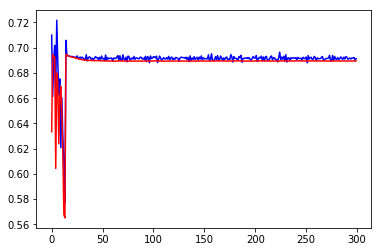

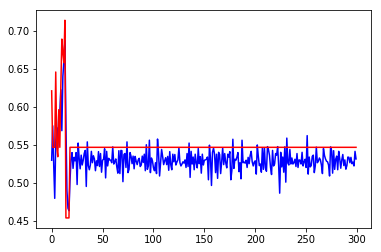

In [28]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [29]:
saveModel(model, run_name_acc)

## 3. Predict

In [30]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

D:\Kaggle\statoil-iceberg-classifier-challenge\output\SC_Iceberg_Classifier_CNN_3channel_VGG19_FineTune_20180110_084730_6894.csv


In [31]:
test_prob = model.predict(x_test)
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

(8424, 1)
[[ 0.47162208]
 [ 0.47162208]]
(8424, 1)
[[ 0.47162208]
 [ 0.47162208]]


In [32]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

         id  is_iceberg
0  5941774d    0.471622
1  4023181e    0.471622
(8424, 2)


In [33]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')

time cost: 26410.34 s
Done!


In [34]:
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_VGG19_FineTune_20180110_084730_6894
